# CTC version 1




### Paper Reference
- [Connectionist Temporal Classification (IDSIA)](ftp://ftp.idsia.ch/pub/juergen/icml2006.pdf)


### English Test
First we test English



In [1]:
# Include And 
import sys
sys.path.append("/home/pika/nntools/")

import theano
import theano.tensor as T
import numpy as np
from theano_toolkit import utils as U
from theano_toolkit import updates
from theano.printing import Print
from theano_toolkit.parameters import Parameters

import lasagne
from lasagne.layers import *

from time import time

import ctc_cost_2

import cPickle
import sys
sys.setrecursionlimit(100000)

from random import shuffle

Using gpu device 0: GeForce GTX 980
/home/pika/nntools/lasagne/init.py:86: UserWarning: The uniform initializer no longer uses Glorot et al.'s approach to determine the bounds, but defaults to the range (-0.01, 0.01) instead. Please use the new GlorotUniform initializer to get the old behavior. GlorotUniform is now the default for all layers.
  warnings.warn("The uniform initializer no longer uses Glorot et al.'s "


# Data


In [2]:
'''
Doing : 
    - Read data and return x_test, y_test
'''
# TRAINING_ACOUSTIC_FEATURE = "./dataCebuano/train.f0_ffv_fbank.fea"
# TRAINING_ACOUSTIC_FEATURE = "./dataCebuano/train_Normalized_SELFVALID.ark"
# TRAINING_ACOUSTIC_FEATURE = "./dataCebuano/train_Normalized_SELFVALID_LenLessThen500.ark"
# TRAINING_LABELS = "./dataCebuano/train.txt"

# TESTING_ACOUSTIC_FEATURE = './dataCebuano/dev_Normalized_SELFVALID_originLength.ark'
TESTING_ACOUSTIC_FEATURE = './dataCebuano/dev_Normalized_SELFVALID_LenLessThen500.ark'
TESTING_LABELS = './dataCebuano/dev.txt'


CHAR_CORPUS = "./dataCebuano/corpus.txt"


def readDataSet () :
    
    # -- Mapping char to integer and reverse
    char_map = {}    # eg. { a -> 1 }
    char_unMap = {}  # eg. { 1 -> a }
    with open( CHAR_CORPUS, 'r' ) as f:
        char_index = 0
        for lines in f:
            char_map  [ lines[:-1] ] = char_index
            char_unMap[ char_index ] = lines[:-1]
            char_index += 1
        # add Blank, take '.' as blank (not space)
        char_map['.'] = char_index
        char_unMap[char_index] = '.'
    
    
    # -- Reading X = id -> [ list of feature ] 
    idMapX = {}
    idDeck = []
    id = ''
    
    tmp_l = 0;
    with open( TESTING_ACOUSTIC_FEATURE, 'r') as f:
        for lines in f: 
            if '[' in lines :
                id = lines.split(' ')[0]
                idDeck.append(id)
                idMapX[id] = []
            elif ']' in lines :
                if( len( lines.split('\n')[0].split(' ') [0:-1] ) != 33 ) :
                    print "err"
                    return 
                idMapX[id].append([float(x) for x in lines.split('\n')[0].split(' ') [:-1] ])
            else :
                if( len( lines.split('\n')[0].split(' ')) != 33 ):
                    print len( lines.split('\n')[0].split(' '))
                    print lines.split('\n')[0].split(' ')
                    print lines
                    print id
                    print "fuck"
                    return
                idMapX[id].append([float(x) for x in lines.split('\n')[0].split(' ') ])
    
    # Move to  3 - main - 3
    
    monoDimension = 33;
    zeroFeature = [0] * monoDimension
    #print len( zeroFeature ) 
    #print zeroFeature
    for id in idDeck:
        # print id
        tmpIdMapXWithID = []
        if len(idMapX[id]) < 6 :
            print "ERROR in length"
            return 
        for idxX in xrange( len(idMapX[id]) ):
            if idxX == 0:
                tmpIdMapXWithID.append( zeroFeature + zeroFeature + zeroFeature + idMapX[id][idxX] + idMapX[id][idxX+1] + idMapX[id][idxX+2] + idMapX[id][idxX+3] )    
            elif idxX == 1:
                tmpIdMapXWithID.append( zeroFeature + zeroFeature + idMapX[id][idxX-1] + idMapX[id][idxX] + idMapX[id][idxX+1] + idMapX[id][idxX+2] + idMapX[id][idxX+3] )  
            elif idxX == 2:
                tmpIdMapXWithID.append( zeroFeature + idMapX[id][idxX-2] + idMapX[id][idxX-1] + idMapX[id][idxX] + idMapX[id][idxX+1] + idMapX[id][idxX+2] + idMapX[id][idxX+3] )  
            elif idxX == (len(idMapX[id]) - 3 ):
                tmpIdMapXWithID.append( idMapX[id][idxX-3] + idMapX[id][idxX-2] + idMapX[id][idxX-1] + idMapX[id][idxX] + idMapX[id][idxX+1] + idMapX[id][idxX+2] + zeroFeature )  
            elif idxX == (len(idMapX[id]) - 2 ):
                tmpIdMapXWithID.append( idMapX[id][idxX-3] + idMapX[id][idxX-2] + idMapX[id][idxX-1] + idMapX[id][idxX] + idMapX[id][idxX+1] + zeroFeature + zeroFeature )  
            elif idxX == (len(idMapX[id]) - 1 ):
                tmpIdMapXWithID.append( idMapX[id][idxX-3] + idMapX[id][idxX-2] + idMapX[id][idxX-1] + idMapX[id][idxX] + zeroFeature + zeroFeature + zeroFeature )  
            else:
                tmpIdMapXWithID.append( idMapX[id][idxX-3] + idMapX[id][idxX-2] + idMapX[id][idxX-1] + idMapX[id][idxX] + idMapX[id][idxX+1] + idMapX[id][idxX+2] + idMapX[id][idxX+3] )  
        idMapX[id] = tmpIdMapXWithID
    
    print "Concate"
    
    # Standardlize X (Done in PrepreProcessing )
   
    id_test = idDeck
    
    idMapY = {} 
    
    checkPara = 0
    # -- Reading Y = id -> [ Sentence(list of char[int] ) ]
    with open( TESTING_LABELS, 'r') as f:
        specific = '?'
        for lines in f:
            yWithId = lines.split('\n')[0].split(' ', 1)
            idMapY[ yWithId[0] ] = []
            judgeSpecific = False
            for char in yWithId[1] :
                if char == '(' and checkPara == 0 : 
                    checkPara = 3
                elif checkPara > 0 :
                    checkPara -= 1
                    if checkPara == 0 :
                        idMapY[ yWithId[0] ].append( char_map[specific] )
                else :
                    if char == '<' :
                        judgeSpecific = True;                
                    if( judgeSpecific ):
                        if char == '>':
                            idMapY[ yWithId[0] ].append( char_map[specific] )
                            judgeSpecific = False
                    else :
                        idMapY[ yWithId[0] ].append( char_map[char.lower()] )
    
    # -- concatenate X and Y
    x_test = []
    y_test = []
    idCollect = []
    for id in id_test:
        concateId = []
        for i in range( len( idMapX[id] ) ) :
            concateId.append( idMapX[id][i] )
        x_test.append( floatX( concateId )  )
        y_test.append( floatX( idMapY[id]) )
        idCollect.append( id )
    
    print "Dataset Finish : "
    print "total x_test = " + str(len(x_test))
    print x_test[0]
    print "total y_test = " + str(len(y_test))
    print y_test[0]
    
    return char_map, char_unMap, x_test, y_test, idCollect

def floatX(x):
    return np.asarray(x, dtype=theano.config.floatX)

# Original 4381
# lessthen500 4157

char_map, char_unMap, x_test, y_test, idCollect = readDataSet()

Concate
Dataset Finish : 
total x_test = 4157
[[ 0.          0.          0.         ...,  0.80623442  0.87935519
   2.1857326 ]
 [ 0.          0.          0.         ...,  0.55712402  1.00187135
   1.96597409]
 [ 0.          0.          0.         ...,  0.39103299  0.83919752
   2.55425239]
 ..., 
 [ 0.83257371  0.8675769   0.23479289 ...,  0.          0.          0.        ]
 [ 0.9678601   0.89204186  0.23479289 ...,  0.          0.          0.        ]
 [ 1.19436431  0.95320964  0.19766235 ...,  0.          0.          0.        ]]
total y_test = 4157
[ 24.  19.  12.  28.   5.   1.   0.  14.  24.  16.  24.  22.  25.   5.   0.
  16.   5.  19.   0.  12.  16.  18.   0.  19.  10.   5.   0.   8.  29.   5.
  16.   0.  10.   5.  19.  12.  19.   5.   0.  15.  24.  19.   0.  21.   5.
  22.   5.  23.   0.  14.   5.   9.  25.  18.   0.  15.  24.  19.]


In [3]:
# 500 -> 3722 / 195
# 600 -> 3821 / 201
# 3000 -> 3937 / 207
print x_test[0].shape
print y_test[0].shape

(288, 231)
(58,)


In [4]:
len(x_test)

4157

In [5]:
print max( [X.shape[0] for X in x_test] )
print max( [Y.shape[0] for Y in y_test] )

501
127


In [6]:

'''
def make_batches_X(XLen, X, length, batch_size=30):
    n_batches = int(round(XLen*1./batch_size))
    X_batch = np.zeros( (n_batches, batch_size, length, X[0].shape[1]),
                       dtype=theano.config.floatX)
    X_mask  = np.zeros( (n_batches, length, batch_size ), 
                       dtype=theano.config.floatX)

    count = 0
    for b in range(n_batches): 
        for n in range(batch_size): # go thorough batch size
            
            if ( XLen > (b*batch_size + n )):
                count += 1
                
                X_m = X[b*batch_size + n] # seq_length X feature dim
                X_batch[b, n, :X_m.shape[0]] = X_m[:length]
                X_mask[b, :X_m.shape[0], n] = 1
    print count
            
    return X_batch, X_mask

'''

def make_batches_X(X, length, batch_size=30):
    n_batches = len(X)//batch_size
    X_batch = np.zeros( (n_batches, batch_size, length, X[0].shape[1]),
                         dtype=theano.config.floatX)
    X_mask  = np.zeros( (n_batches, length, batch_size ), 
                         dtype=theano.config.floatX)
    
    for b in range(n_batches): 
        for n in range(batch_size): # go thorough batch size       
            X_m = X[b*batch_size + n] # seq_length X feature dim            
            X_batch[b, n, :X_m.shape[0]] = X_m[:length]
            X_mask[b, :X_m.shape[0], n] = 1
            
    return X_batch, X_mask

def make_batches_Y( X, length, batch_size=30):
    n_batches = len(X)//batch_size
    
    X_batch = np.zeros( (n_batches, length, batch_size ), dtype='float32')
    
    X_mask = np.zeros(X_batch.shape, dtype=theano.config.floatX)
    
    for b in range(n_batches):
        for n in range(batch_size):
            X_m = X[ b*batch_size + n ]
            X_batch[b, :X_m.shape[0], n ] = X_m[:length]
            X_mask[b, :X_m.shape[0], n] = 1
    return X_batch, X_mask

In [7]:
'''
batch_size = 12

# Find the longest sequence
# length_x = max( [X.shape[0] for X in x_test] )

# length_x = 1670
length_y = 206

# Convert to batches of time series of uniform length
# x_test_mask: seq_length X batch_size
# y_test_mask: output_length X batch_size
# y_pred_mask = x_test_mask, since pred by sequence


# x_test, x_test_mask = make_batches_X(len(x_test), x_test, length_x, batch_size)
y_test, y_test_mask = make_batches_X(len(y_test), y_test, length_y, batch_size)
'''

batch_size = 40
# batch_size = 12

# Find the longest sequence
length_x = max( [X.shape[0] for X in x_test] )
length_y = max( [X.shape[0] for X in y_test] )

# Convert to batches of time series of uniform length
# x_train_mask: seq_length X batch_size
# y_train_mask: output_length X batch_size
# y_pred_mask = x_train_mask, since pred by sequence
x_test, x_test_mask = make_batches_X(x_test, length_x, batch_size)
y_test, y_test_mask = make_batches_Y(y_test, length_y, batch_size)



In [8]:
print x_test.shape
print y_test.shape
print "===============mask================"
print x_test_mask.shape
print y_test_mask.shape

# print x_test_mask[0][400][0]

(103, 40, 501, 231)
(103, 127, 40)
===============mask================
(103, 501, 40)
(103, 127, 40)


# Model Part


In [9]:
def _count_grade( r, h):
    d = np.zeros((len(r)+1)*(len(h)+1), dtype=np.uint8)
    d = d.reshape((len(r)+1, len(h)+1))
    for i in range(len(r)+1):
        for j in range(len(h)+1):
            if i == 0:
                d[0][j] = j
            elif j == 0:
                d[i][0] = i
    # computation
    for i in range(1, len(r)+1):
        for j in range(1, len(h)+1):
            if r[i-1] == h[j-1]:
                d[i][j] = d[i-1][j-1]
            else:
                substitution = d[i-1][j-1] + 1
                insertion    = d[i][j-1] + 1
                deletion     = d[i-1][j] + 1
                d[i][j] = min(substitution, insertion, deletion)
    point = float(d[len(r)][len(h)])/float(len(r))
    # print point 
    return point

In [10]:
print _count_grade( "hello", "hi")

0.8


In [11]:
'''
credit by NLTK package of measure edit distance
'''

def _edit_dist_init(len1, len2):
    lev = []
    for i in range(len1):
        lev.append([0] * len2)  # initialize 2D array to zero
    for i in range(len1):
        lev[i][0] = i           # column 0: 0,1,2,3,4,...
    for j in range(len2):
        lev[0][j] = j           # row 0: 0,1,2,3,4,...
    return lev


def _edit_dist_step(lev, i, j, s1, s2, transpositions=False):
    c1 = s1[i - 1]
    c2 = s2[j - 1]

    # skipping a character in s1
    a = lev[i - 1][j] + 1
    # skipping a character in s2
    b = lev[i][j - 1] + 1
    # substitution
    c = lev[i - 1][j - 1] + (c1 != c2)

    # transposition
    d = c + 1  # never picked by default
    if transpositions and i > 1 and j > 1:
        if s1[i - 2] == c2 and s2[j - 2] == c1:
            d = lev[i - 2][j - 2] + 1

    # pick the cheapest
    lev[i][j] = min(a, b, c, d)


def check_label_error( real , predict, transpositions=False):
    ## length of real >= length of predict
    """
    Calculate the Levenshtein edit-distance between two strings.
    The edit distance is the number of characters that need to be
    substituted, inserted, or deleted, to transform s1 into s2.  For
    example, transforming "rain" to "shine" requires three steps,
    consisting of two substitutions and one insertion:
    "rain" -> "sain" -> "shin" -> "shine".  These operations could have
    been done in other orders, but at least three steps are needed.

    This also optionally allows transposition edits (e.g., "ab" -> "ba"),
    though this is disabled by default.

    :param s1, s2: The strings to be analysed
    :param transpositions: Whether to allow transposition edits
    :type s1: str
    :type s2: str
    :type transpositions: bool
    :rtype int
    """
    # set up a 2-D array
    len1 = len(predict)
    len2 = len(real)
    lev = _edit_dist_init(len1 + 1, len2 + 1)

    # iterate over the array
    for i in range(len1):
        for j in range(len2):
            _edit_dist_step(lev, i + 1, j + 1, predict, real, transpositions=transpositions)
            
    return lev[len1][len2]*1.0/len2


def clean_up( y ):
    """
    for final output clean up
    B(a − ab−) = B(−aa − −abb) = aab
    """
    answer = ""

    for i in range(len(y)):
        if y[i] == '.':
            continue
        else:
            if y[i-1] != y[i]:
                answer += y[i]
    
    return answer

def remap_back( y , actual):
    answer = ""
    
    for i in y:
        answer += char_unMap[i]
    
    if not actual:
        answer = clean_up(answer)
        
    return answer

def decode_all_actual( y, y_mask ,batch_size , actual=False):
    """
    y     : label_length X batch_size
    y_mask: label_length X batch_size
    """
    result = []
    for i in xrange(batch_size):
        mask = np.swapaxes( y_mask, 0, 1)[i]
        ans = np.swapaxes( y, 0 , 1)[i]
        result.append(remap_back( ans[np.nonzero(mask)] , actual ))
    return result


def decode_all_pred( y, y_mask ,batch_size , actual=False):
    """
    y     : label_length X batch_size
    y_mask: label_length X batch_size
    """
    result = []
    for i in xrange(batch_size):
        mask = np.swapaxes( y_mask, 0, 1)[i]
        ans = y[i]
        result.append(remap_back( ans[np.nonzero(mask)] , actual ))
    return result

def check_all( y, y_mask, y_pred, y_pred_mask, batch_size ):
    
    actual = decode_all_actual( y, y_mask, batch_size , True )
    predict = decode_all_pred( y_pred, y_pred_mask, batch_size , False )
    
    error = 0.
    for a,b in zip (actual, predict):
        error += check_label_error(a,b)
    
    return error/len(actual)

In [12]:
class end_to_end():  
    def __init__(self, input_shape, max_seq_length, hidden_layer,
                 batch, max_epochs, output_num_units,
                 patience, up_learning_rate, file_name):
        
        self.input_shape = input_shape # [batch, dim]
        
        self.hidden_layer = hidden_layer # hidden [l1, l2, l3]
        self.output_num_units = output_num_units # [ # of class ]
        
        self.batch = batch
        self.max_epochs = max_epochs
        
        self.up_learning_rate = up_learning_rate
                 
        self.patience = patience
        self.best_valid = np.inf
        self.best_valid_epoch = 0
        self.best_params = None
        
        self.train_history_ = []
        self.epochs = 0
        
        self.file_name = file_name
        
        self.max_seq_length = max_seq_length
        
        """
        input data type
        y_hat : T x B x C+1
        y : L x B
        y_hat_mask : T x B
        y_mask : L x B
        """
        
        print "Why model build so long ... "
        # T x B x F
        # B X T X F (Lasagne format)
        x = T.tensor3('X', dtype=theano.config.floatX)
        # L x B
        y = T.matrix ('y', dtype=theano.config.floatX)

        # L x B
        y_mask = T.matrix('y_mask', dtype=theano.config.floatX)
        # T x B
        y_hat_mask = T.matrix('y_hat_mask', dtype=theano.config.floatX)
    
        # Min/max sequence length
        MAX_LENGTH = max_seq_length
        
        # Number of training sequences in each batch
        N_BATCH = batch
        
        #===========================================================================================
        # dEEP lSTM
        #===========================================================================================
        print "Input : (N_BATCH) : " + str(N_BATCH) +", ML :" + str(MAX_LENGTH) + "ss :" + str(self.input_shape[1])
        
        # Recurrent layers expect input of shape
        # (batch size, max sequence length, number of features)
        l_in     = lasagne.layers.InputLayer( shape=( N_BATCH, MAX_LENGTH, self.input_shape[1] ) )
        # l_in_gau = lasagne.layers.GaussianNoiseLayer( l_in, sigma=0.5 )
        
        # LSTM layer 1
        l_forward_1   = lasagne.layers.LSTMLayer(l_in, num_units=hidden_layer[0], learn_init=True, peepholes=True)
        l_backward_1  = lasagne.layers.LSTMLayer(l_in, num_units=hidden_layer[0], backwards=True, learn_init=True, peepholes=True)
        l_recurrent_1 = ElemwiseSumLayer( [l_forward_1, l_backward_1] )

        
        # LSTM layer 2
        l_forward_2   = lasagne.layers.LSTMLayer(l_recurrent_1, num_units=hidden_layer[1], learn_init=True, peepholes=True)
        l_backward_2  = lasagne.layers.LSTMLayer(l_recurrent_1, num_units=hidden_layer[1], backwards=True, learn_init=True, peepholes=True)
        l_recurrent_2 = ElemwiseSumLayer( [l_forward_2, l_backward_2] )
        
        # LSTM layer 3
        l_forward_3   = lasagne.layers.LSTMLayer(l_recurrent_2, num_units=hidden_layer[2], learn_init=True, peepholes=True)
        l_backward_3  = lasagne.layers.LSTMLayer(l_recurrent_2, num_units=hidden_layer[2], backwards=True, learn_init=True, peepholes=True)
        l_recurrent_3 = ElemwiseSumLayer( [l_forward_3, l_backward_3] )
        '''
        # LSTM layer 4
        l_forward_4   = lasagne.layers.LSTMLayer(l_recurrent_3, num_units=hidden_layer[3], learn_init=True, peepholes=True)
        l_backward_4  = lasagne.layers.LSTMLayer(l_recurrent_3, num_units=hidden_layer[3], backwards=True, learn_init=True, peepholes=True)
        l_recurrent_4 = ElemwiseSumLayer( [l_forward_4, l_backward_4] )
        '''
        
        #l_reshape = lasagne.layers.ReshapeLayer(l_recurrent_4, (N_BATCH*MAX_LENGTH, hidden_layer[3])  )
        l_reshape = lasagne.layers.ReshapeLayer(l_recurrent_3, (N_BATCH*MAX_LENGTH, hidden_layer[2])  )

        
        #===========================================================================================
        # COMMON SETUP
        #===========================================================================================
        
        # Our output layer is a simple dense connection
        l_recurrent_out      = lasagne.layers.DenseLayer( l_reshape, num_units=output_num_units[0] , nonlinearity=lasagne.nonlinearities.identity)
        
        # Now, reshape the output back to the RNN format
        l_out_shp            = lasagne.layers.ReshapeLayer( l_recurrent_out, (N_BATCH, MAX_LENGTH, output_num_units[0]) )
        
        # dimshuffle to shape format (input_seq_len, batch_size, num_classes + 1)
        l_out_shp_ctc        = lasagne.layers.DimshuffleLayer( l_out_shp, (1, 0, 2))

        l_out_softmax        = lasagne.layers.NonlinearityLayer( l_recurrent_out, nonlinearity=lasagne.nonlinearities.softmax)
        l_out_softmax_shp    = lasagne.layers.ReshapeLayer( l_out_softmax, (N_BATCH, MAX_LENGTH, output_num_units[0] ))
        
        # since we use gaussian noise in input, False means use noise, True means dont use noise
        output_lin_ctc_train = lasagne.layers.get_output( l_out_shp_ctc, x, deterministic=False)
        output_softmax_train = lasagne.layers.get_output( l_out_softmax_shp, x, deterministic=False)
        
        output_lin_ctc_val   = lasagne.layers.get_output(l_out_shp_ctc, x, deterministic=True)
        output_softmax_val   = lasagne.layers.get_output(l_out_softmax_shp, x, deterministic=True)
        
        self.all_params      = lasagne.layers.get_all_params(l_out_shp)

        # the CTC cross entropy between y and linear output network
        pseudo_cost = ctc_cost_2.pseudo_cost(
            y, output_lin_ctc_train, y_mask, y_hat_mask,
            skip_softmax=True)
        
        
        pseudo_cost_grad = T.grad(pseudo_cost.mean(), self.all_params)
        true_cost        = ctc_cost_2.cost(y, output_softmax_train.dimshuffle(1, 0, 2), y_mask, y_hat_mask)
        cost             = T.mean(true_cost)
        updates          = lasagne.updates.rmsprop(pseudo_cost_grad, self.all_params, learning_rate = self.up_learning_rate)

        self.train = theano.function(
            inputs = [x, y, y_hat_mask, y_mask],
            outputs = [ pseudo_cost.mean(), cost, output_softmax_train ],
#             outputs = [output_lin_ctc, output_softmax, cost],
            updates=updates
        )
        
        self.predict = theano.function( 
            inputs=[x], 
            outputs = [ output_softmax_val] 
        )

        
    # x_mask and y_mask is the same
    # x_test_mask and y_test_mask is the same
    def fit(self, x_train, y_train, x_test,  y_test , x_mask, y_mask, x_test_mask, y_test_mask ):
        print " "
        print "start training!!!!"
        print " "
        sys.stdout.flush()
        
        for i in range(self.max_epochs):
            self.epochs +=1
            t0 = time()
            
            cs = 0.
            pseudo_cs = 0.
            for index in range(len(x_train)):
                pseudo, cost, output_softmax = self.train( x_train[index] , y_train[index],
                                                          x_mask[index], y_mask[index])
                cs += cost
                pseudo_cs += pseudo
                gg = index
                if index % 10 == 0:
                    print index, pseudo, cost
                sys.stdout.flush()
            
            cs /= len(x_train)
            pseudo_cs /= len(x_train)
            
#             cPickle.dump( self , open("./"+self.file_name+".pkl","wb"))
            if self.epochs <= 1:
                previous_cs = "-"
            else:
                previous_cs = self.train_history_[-1]['cost']
            print "\n==============================="
            print 'epoch {0} : pseudo= {1}, cost= {2}, previous_cost= {3}, train_time = {4} s'.format(self.epochs,
                                                                                                      pseudo_cs, 
                                                                                                      cs,
                                                                                                      previous_cs, 
                                                                                                      time() - t0)
            
            sys.stdout.flush()
            
            t0 = time()
            
#             print np.argmax(output_softmax[:],axis=2)
#             print decode_all( np.argmax(output_softmax[:],axis=2) , x_train_mask[gg],  batch_size , True)
            
            # save model first
            # dont know the LER performance yet
#             cPickle.dump( self , open("./"+self.file_name+".pkl","wb"))
    

            label_error_rate = 0.
            print len(x_test)
            for index in range( len(x_test) ) :

                prepre = self.predict( x_test[index])
                
                label_error_rate += check_all( y_test[index], y_test_mask[index],
                                              np.argmax(prepre[0],axis=2) , x_test_mask[index],
                                              batch_size)
                
                if (( index + self.epochs ) % 4 == 0 ):
                    ## print actual
                    y_actual = decode_all_actual( y_test[index], y_test_mask[index], batch_size , True)

                    ## print pred
                    y_predict = decode_all_pred( np.argmax(prepre[0],axis=2) , x_test_mask[index],  batch_size , False)
                
            label_error_rate /= len(x_test)
            self.train_history_.append({"epoch":self.epochs, "cost": cs, "LER":label_error_rate})
            
            print '\t\t\t val_= {0}, test_time  = {1} s'.format(label_error_rate, time() - t0)
            print "===============================\n"
            
            sys.stdout.flush()
            
            for a , b in zip (y_actual,y_predict):
                print "Target== ",a 
                print "\tAns => ",b
            
            sys.stdout.flush()
            
            """
            should use cost do early stopping
            """
            current_cs = self.train_history_[-1]['cost']
            current_epoch = self.train_history_[-1]['epoch']
            if current_cs < self.best_valid:
                self.best_valid = current_cs
                self.best_valid_epoch = current_epoch
                self.best_params = [w.get_value() for w in self.all_params]
                cPickle.dump( self , open("./"+self.file_name+".pkl","wb"))
                
            elif self.best_valid_epoch + self.patience <= current_epoch:
                print ""
                print "Early stopping."
                print self.best_valid_epoch,self.best_valid
                print "Best valid ler {:.6f} at epoch {}.".format(self.best_valid, self.best_valid_epoch)              
#                 for qq in range (len(self.all_params)):
#                     self.all_params[qq].set_value( self.best_params[qq] )
#                 break

            """
            can not use label error rate do early stopping
            """
#             current_ler = self.train_history_[-1]['LER']
#             current_epoch = self.train_history_[-1]['epoch']
#             if current_ler < self.best_valid:
# #                 print "********************* Now best ************************"
#                 sys.stdout.flush()
#                 self.best_valid = current_ler
#                 self.best_valid_epoch = current_epoch
#                 self.best_params = [w.get_value() for w in self.all_params]
# #                 cPickle.dump( self , open("./"+self.file_name+".pkl","wb"))
                
#             elif self.best_valid_epoch + self.patience <= current_epoch:
#                 print ""
#                 print "Early stopping."
#                 print self.best_valid_epoch,self.best_valid
#                 print "Best valid ler {:.6f} at epoch {}.".format(self.best_valid, self.best_valid_epoch)
#                 sys.stdout.flush()                
#                 for qq in range (len(self.all_params)):
#                     self.all_params[qq].set_value( self.best_params[qq] )
#                 break


#     def prediction(self, x, x_mask) :
        
#         abc =  self.predict(x, x_mask)
        
#         return np.argmax(abc[0], axis = 1 )




# ONE LAYER, Predict


    model1L_noNoise_with212 = end_to_end (
        input_shape      = (1, x_train.shape[3] ) , # batch of 1, (110, 30, 777, 117)
        max_seq_length = x_train.shape[2],
        hidden_layer     = [ 250, 250, 250, 250 ], # maximum layer to LSTM 3 layer only
        batch            = batch_size, 
        max_epochs       = 300, 
        output_num_units = [ len(char_unMap) ],
        up_learning_rate = 0.0001, 
        patience         = 7,
        file_name = "model1L_noNoise_with212"
    )


### Saved Model
Model name = model1L_noNoise_with212_e119bkp.pkl

'''

In [116]:
import gc
gc.collect()

# del model1

#with open('model1L_noNoise_with212_e119bkp.pkl', 'rb') as f:
with open('model3L_noNoise_with313.pkl', 'rb') as f:
    model2L_noNoise_with212 = cPickle.load(f)


105
          LER        cost  epoch
0    0.950906  744.413847      1
1    0.974980  526.876358      2
2    0.971795  419.600052      3
3    0.969559  404.582801      4
4    0.972455  348.387741      5
5    0.969049  344.731912      6
6    0.971434  329.233195      7
7    0.973187  319.751469      8
8    0.962926  308.091752      9
9    0.972161  312.335877     10
10   0.969432  305.340088     11
11   0.971113  288.470282     12
12   0.976472  279.366737     13
13   0.975531  260.094709     14
14   0.967937  251.891285     15
15   0.973179  255.547224     16
16   0.968212  258.676144     17
17   0.973366  261.783359     18
18   0.969635  252.873084     19
19   0.968440  247.299661     20
20   0.960664  251.853169     21
21   0.967575  250.128184     22
22   0.967189  235.680103     23
23   0.961196  237.743857     24
24   0.966802  243.532059     25
25   0.960706  228.377939     26
26   0.967467  217.454952     27
27   0.963691  209.935082     28
28   0.964657  206.752137     29
29   0

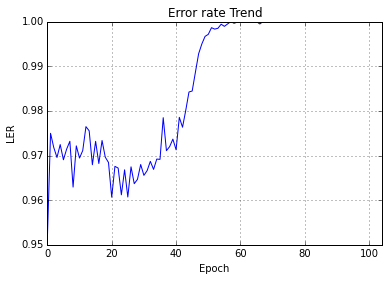

In [117]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
pd.__version__
%matplotlib inline

print len(model2L_noNoise_with212.train_history_)
histo = pd.DataFrame(model2L_noNoise_with212.train_history_)

print histo
print histo['LER'].describe()

my_plot = histo['LER'].plot(title="Error rate Trend",legend=None)
my_plot.set_xlabel("Epoch")
my_plot.set_ylabel("LER")


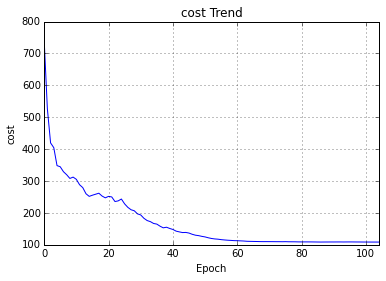

In [118]:
my_plot2 = histo['cost'].plot(title="cost Trend",legend=None)
my_plot2.set_xlabel("Epoch")
my_plot2.set_ylabel("cost")


In [119]:
histo.to_pickle('./ver1-L3-313-nonoise.pa')

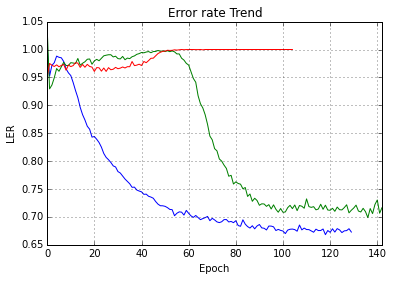

In [120]:
l1histo = pd.read_pickle('./ver1-L1-313-nonoise.pa')
l2histo = pd.read_pickle('./ver1-L2-313-nonoise.pa')
l3histo = pd.read_pickle('./ver1-L3-313-nonoise.pa')

my_plot3 = l1histo['LER'].plot(title="Error rate Trend",legend=None)
my_plot3 = l2histo['LER'].plot(legend=None)
my_plot3 = l3histo['LER'].plot(legend=None)
my_plot3.set_xlabel("Epoch")
my_plot3.set_ylabel("LER")
fig = my_plot3.get_figure()
fig.savefig("l1TOl3Tmp.png")


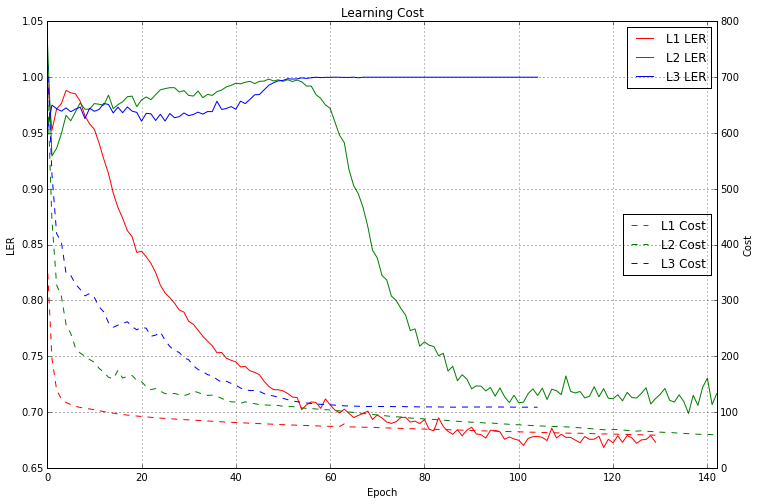

In [121]:
# ref : http://stackoverflow.com/questions/16568964/make-a-multiline-plot-from-csv-file-in-matplotlib
# ref : http://pbpython.com/simple-graphing-pandas.html

l1histo = pd.read_pickle('./ver1-L1-313-nonoise.pa')
l2histo = pd.read_pickle('./ver1-L2-313-nonoise.pa')
l3histo = pd.read_pickle('./ver1-L3-313-nonoise.pa')

my_plot3 = l1histo['LER'].plot(label="L1 LER", color='r',legend=True, figsize=(12, 8), sharex=True)
my_plot3 = l2histo['LER'].plot(label="L2 LER", color='g',legend=True)
my_plot3 = l3histo['LER'].plot(label="L3 LER", color='b',legend=True)
plt.legend(loc='best')
my_plot3.set_xlabel("Epoch")
my_plot3.set_ylabel("LER")

my_plot3 = l1histo['cost'].plot(secondary_y=True, style='--', color='r', label="L1 Cost",legend=True)
my_plot3 = l2histo['cost'].plot(secondary_y=True, style='--', color='g', label="L2 Cost",legend=True)
my_plot3 = l3histo['cost'].plot(secondary_y=True, style='--', color='b', label="L3 Cost",legend=True)
my_plot3.set_xlabel("Epoch")
my_plot3.set_ylabel("Cost")
plt.title("Learning Cost")
plt.grid(alpha=0.4) 
plt.legend(loc='center right')
# plt.add_legend()
fig = my_plot3.get_figure()
fig.savefig("L1toL3_charAnal.png")


In [19]:
label_error_rate = 0.
pr_error_rate = 0.
pr_count = 0
print len(x_test)
WRITE_RESULT = "./dataCebuano/dev_predict_result_2L_noNoise_with313_epo137.txt"

with open(WRITE_RESULT, 'w+') as f:
    for index in range( len(x_test) ) :
        prepre = model2L_noNoise_with212.predict( x_test[index])
        ## print actual
        y_actual = decode_all_actual( y_test[index], y_test_mask[index], batch_size , True)
        ## print pred
        y_predict = decode_all_pred( np.argmax(prepre[0],axis=2) , x_test_mask[index],  batch_size , False)
        for a, b in zip( y_actual, y_predict):
            # print "---------"
            # print "Target : ", a
            # print "Predict: ", b
            # print _count_grade(a,b)
            pr_error_rate += _count_grade( a, b)
            f.write(idCollect[pr_count])
            f.write(' ')
            f.write(b);
            f.write('\n');
            pr_count += 1
        
        label_error_rate += check_all( y_test[index], y_test_mask[index],
                         np.argmax(prepre[0],axis=2), x_test_mask[index],
                         batch_size) 

    label_error_rate /= len(x_test)
    pr_error_rate /= pr_count
    print "Total Sentence : ", pr_count
    print "chun label_error_rate : ", label_error_rate
    print "Lee's label_error_rate : ", pr_error_rate

print "Mission Complete"

103
Total Sentence :  4120
chun label_error_rate :  0.764031235273
Lee's label_error_rate :  0.764031235273
Mission Complete


# Only Process once

In [ ]:
''' 
[ Doing : ]
    - Read character from *.txt to build the corpus 

[ Result : ]

-- Without Develope Data:

Building corpus without develope data:
set([' ', "'", '-', '?', '_', 'a', 'c', 'b', 'e', 'd', 'g', 'f', 'i', 'h', 'k', 'j', 'm', 'l', 'o', 'n', 'q', 'p', 's', 'r', 'u', 't', 'w', 'v', 'y', 'x', 'z'])
Total len is : 31
Done Write to [./dataCebuano/corpus.txt]

-- With Develope Data:

Building corpus with develope data:
set([' ', "'", ')', '(', '-', '?', '_', 'a', 'c', 'b', 'e', 'd', 'g', 'f', 'i', 'h', 'k', 'j', 'm', 'l', 'o', 'n', 'q', 'p', 's', 'r', 'u', 't', 'w', 'v', 'y', 'x', 'z'])
Total len is : 33
Done Write to [./dataCebuano/corpus.txt]
'''

TRAINING_LABEL = "./dataCebuano/train.txt"
DEVELOPE_LABEL = "./dataCebuano/dev.txt"
WRITING_TO = "./dataCebuano/corpus.txt"

# Special part to build corpus
def buildCharacterCorpus(withDevelopeData = False) :
    corpus = set( )
    with open(TRAINING_LABEL, 'r') as ft:
        for lines in ft:
            for word in lines.split('\n')[0].split(' ')[1:]:
                if word[0] == '<':
                    # We take every <...> as <unk> 
                    unKnownTag = '?'
                    corpus.add( unKnownTag ) 
                else:
                    for char in word:
                        corpus.add(char.lower())
    
    if( withDevelopeData ) :
        with open(DEVELOPE_LABEL, 'r') as fd:
            for lines in fd:
                for word in lines.split('\n')[0].split(' ')[1:]:
                    if word[0] == '<':
                        unKnownTag = '?'
                        corpus.add( unKnownTag ) 
                        # corpus.add(word.split('\n')[0].lower())
                    else:
                        for char in word:
                            corpus.add(char.lower())
    
    corpus.add(' ')
    print "Building corpus with" + ("" if withDevelopeData else "out") + " develope data:"
    print corpus
    print "Total len is : " + str(len(corpus))
    
    
    with open(WRITING_TO, 'w+') as fw:
        for item in corpus:
            fw.write(item + '\n')        
    print "Done Write to [" + WRITING_TO + "]"
    return corpus

trainingCorpus = buildCharacterCorpus()



In [1]:
# import theano
# from theano import tensor as T
# from theano.sandbox.rng_mrg import MRG_RandomStreams as RandomStreams
import numpy as np

from sklearn import cross_validation as cv
from sklearn import metrics
from sklearn import grid_search as gs
from sklearn.metrics import accuracy_score
from itertools import repeat

#proprocessor
from sklearn import preprocessing
from time import time

from itertools import repeat
import numpy as np
import random
from sklearn import preprocessing


def floatX(X):
    return np.asarray(X, dtype=theano.config.floatX)

def vectorized_result ( j , siz) :
    e = np.zeros((siz, 1))
    e[j] = 1.0
    return np.reshape( e, siz)

# TRAINING_DATA   = './dataCebuano/train.f0_ffv_fbank.fea'
TEST_DATA = './dataCebuano/dev.f0_ffv_fbank.fea'
# TRAIN_ARK  = './dataCebuano/train_Normalized_SELFVALID.ark'

TEST_ARK  = './dataCebuano/dev_Normalized_SELFVALID_LenLessThen500.ark'


def normalizeAndFilterData ( maxLength = 3000) :
    # Dataset
    x_data = []
    x_name = []
    record_seq = []

    with open( TEST_DATA, 'r') as f:
        for lines in f: 
            if '[' in lines :
                id = lines.split(' ')[0]
                x_name.append(id)
                seq = 0
            elif ']' in lines :
                if seq > maxLength :
                    x_name.pop()
                    del x_data[-seq:]
                else :
                    seq += 1
                    record_seq.append(seq)
                    x_data.append([float(x) for x in lines.split(' ') [2:-1] ])
            else :
                seq += 1
                x_data.append([float(x) for x in lines.split(' ') [2:-1] ])

    print "Normalized"
    x_data = preprocessing.scale( np.array(x_data) )

    # x_data[separate+1]
    # x_name
    bitch = record_seq.index(max(record_seq))
    print "Max len is ", record_seq[bitch]
    
    print "Total training data", len(x_name)

    # trainF = open(TRAIN_ARK, 'w+')
    with open(TEST_ARK, 'w+') as trainF:
        currentSeq = 0
        for nameIndex in range( len(x_name) ):

            trainF.write(str(x_name[nameIndex])+"  [\n")

            for valueIndex in range( (record_seq[nameIndex]) ):
                for featureIndex in range( len(x_data[0]) ):
                    if ( featureIndex+1) != len(x_data[0] ) :
                        trainF.write( str(x_data[ currentSeq  + valueIndex][featureIndex]) + " ")
                    else:
                        trainF.write( str(x_data[ currentSeq  + valueIndex][featureIndex]) )
                if valueIndex+1 == (record_seq[nameIndex]):
                    trainF.write(" ]\n")
                else:
                    trainF.write("\n")
            currentSeq += record_seq[nameIndex]

    print "MIssion ComplEte"


normalizeAndFilterData(500)


Normalized
Max len is  501
Total training data 4157
MIssion ComplEte
